### Pipeline


In [1]:
import pandas as pd
import string
import re
import json
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from underthesea import word_tokenize
from transformers import pipeline

In [2]:
corrector = pipeline("text2text-generation", model="./vietnamese-correction-v2")

Device set to use cpu


### Làm sạch dữ liệu (xoá hàng comment trống hoặc nan)


In [3]:
df = pd.read_csv("../data/phone_ratings.csv")

In [4]:
df.shape

(2413, 4)

In [5]:
df[~df["comment"].notna()]

,product_id,comment,rating,source_file
534,iphone-15-plus,NaN,5,ratings\iphone-15-plus.csv
535,iphone-15-plus,NaN,5,ratings\iphone-15-plus.csv
536,iphone-15-plus,NaN,4,ratings\iphone-15-plus.csv
537,iphone-15-plus,NaN,5,ratings\iphone-15-plus.csv
538,iphone-15-plus,NaN,1,ratings\iphone-15-plus.csv
...,...,...,...,...
2288,xiaomi-redmi-a3,NaN,5,ratings\xiaomi-redmi-a3.csv
2289,xiaomi-redmi-a3,NaN,4,ratings\xiaomi-redmi-a3.csv
2290,xiaomi-redmi-a3,NaN,5,ratings\xiaomi-redmi-a3.csv
2291,xiaomi-redmi-a3,NaN,5,ratings\xiaomi-redmi-a3.csv


In [6]:
# Xoá hàng chứa comment trống hoặc nan
df = df[df["comment"].str.len() > 1]

In [7]:
df.shape

(2313, 4)

In [8]:
df[~df["comment"].notna()]

,product_id,comment,rating,source_file


### Pipeline xử lý cho văn bản tiếng Việt


In [ ]:
class VietnamesePreprocessing:
    def __init__(self):
        # Load Vietnamese stopwords
        with open("../data/vietnamese.txt", "r", encoding="utf-8") as file:
            self.stop_words = set(word.strip() for word in file.read().splitlines())
        with open("../data/vi-abbreviations.json", "r", encoding="utf-8") as file:
            self.abbreviations = json.load(file)

    def clean(self, x: str) -> str:
        """Clean the text by removing unwanted characters or patterns."""
        x = re.sub(r"\s+", " ", x)
        x = re.sub(r"[^\w\s]", "", x)
        x = re.sub(r"\b0", "", x)  # remove digit 0 at the beginning

        # remove phone number vietnam like 0954223654, 0856452325, 0123456789
        x = re.sub(r"(\d{10})", "", x)

        # remove phone number vietnam like xxx223654 hay 0905***654
        x = re.sub(r"(xx\s*){2,}", "", x)
        x = re.sub(r"(\*\s*)+", "", x)

        # remove number stand alone
        x = re.sub(r"\b\d+\b", "", x)
        x = re.sub(r"\b(?:\d{3}|\d{2})[xX]*\d{6,10}\b", "", x)
        x = re.sub(r"\b(?:\d{4}|\d{3})[xX]*\d{6,10}\b", "", x)
        x = x.strip()  # Remove leading/trailing spaces
        return x

    def to_lower(self, x: str) -> str:
        """Convert all text to lowercase."""
        return x.lower()

    def delete_punctuation(self, x: str) -> str:
        """Remove punctuation from the text."""
        return x.translate(str.maketrans("", "", string.punctuation))

    def tokenize_text(self, x: str) -> list:
        """Tokenize the text into words."""
        return word_tokenize(x)

    def delete_stop_words(self, x: str) -> str:
        """Remove stopwords from the text."""
        return " ".join([word for word in x.split() if word not in self.stop_words])

    def replace_abbreviations(self, x: str) -> str:
        """Replace abbreviations in the text using the loaded dictionary."""
        return " ".join([self.abbreviations.get(word, word) for word in x.split()])

    def correct_spelling(self, x: str) -> str:
        """Correct spelling using the loaded model."""
        return corrector(x, max_length=2500)[0]["generated_text"]

    def __call__(self, x: str):
        """Apply the preprocessing pipeline to the input text."""
        print("Before:", x)
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.delete_punctuation(x)
        x = self.replace_abbreviations(x)
        x = self.correct_spelling(x)
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.delete_punctuation(x)

        print("After: ", x)
        # x = self.delete_stop_words(x)  # Remove stopwords
        return x


preprocessor = VietnamesePreprocessing()

for idx, row in df.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df.at[idx, "comment"] = preprocessor(row["comment"])  # Apply preprocessing

=====> Processing row 1
Before: đừng mua không có linh kiện
After:  đừng mua không có linh kiện
=====> Processing row 2
Before: máy sao cũng được ghét nhất cái zalo vui nó báo hiện tên cuộc gọi
After:  máy sao cũng được ghét nhất cái zalo vui nó báo hiện tên cuộc gọi
=====> Processing row 3
Before: chiếc điện thoại mỏng nhất tôi từng dùng cũng là chip trên máy này mượt hơn
After:  chiếc điện thoại mỏng nhất tôi từng dùng cũng là chip trên máy này mượt hơn
=====> Processing row 4
Before: sao hôm tôi mua lại không được tặng tai nghe như trong giới thiệu nhỉ hôm đấy
After:  sao hôm tôi mua lại không được tặng tai nghe như trong giới thiệu nhỉ hôm đấy
=====> Processing row 5
Before: em mua được tuần trả lại mất bao nhiêu ạ
After:  em mua được tuần trả lại mất bao nhiêu ạ
=====> Processing row 6
Before: thế giới di động có cường lực của honor không ạ
After:  thế giới di động có cường lực của honor không ạ
=====> Processing row 7
Before: không có nhưng rất tiếc honor quá lạc hậu so với nhiều

In [17]:
df.to_csv("../data/phone_ratings_cleaned_new.csv", index=False)

In [41]:
text ='0905*****440'
text = re.sub(r"(xx\s*){2,}", "", text)
re.sub(r"(\*\s*)+", "", text)

'0905440'

### Chạy lại pipeline (không có bước spell check)

In [100]:
df = pd.read_csv("../data/phone_ratings_cleaned_new.csv")
df= df[df["comment"].str.len() >1]

In [101]:
class VietnamesePreprocessing:
    def __init__(self):
        # Load Vietnamese stopwords
        with open("../data/vietnamese.txt", "r", encoding="utf-8") as file:
            self.stop_words = set(word.strip() for word in file.read().splitlines())
        with open("../data/vi-abbreviations.json", "r", encoding="utf-8") as file:
            self.abbreviations = json.load(file)
        with open("../data/compound_words.txt", "r", encoding="utf-8") as file:
            self.compound_words = set(word.strip() for word in file.read().splitlines())

    def clean(self, x: str) -> str:
        """Clean the text by removing unwanted characters or patterns."""
        x = re.sub(r"\s+", " ", x)
        x = re.sub(r"[^\w\s]", "", x)
        x = re.sub(r"\b0", "", x)  # remove digit 0 at the beginning

        # remove phone number vietnam like 0954223654, 0856452325, 0123456789
        x = re.sub(r"(\d{10})", "", x)

        # remove phone number vietnam like xxx223654 hay 0905***654
        x = re.sub(r"(xx\s*){2,}", "", x)
        x = re.sub(r"(\*\s*)+", "", x)

        # remove number stand alone
        x = re.sub(r"\b\d+\b", "", x)
        x = re.sub(r"\b(?:\d{3}|\d{2})[xX]*\d{6,10}\b", "", x)
        x = re.sub(r"\b(?:\d{4}|\d{3})[xX]*\d{6,10}\b", "", x)
        x = x.strip()  # Remove leading/trailing spaces
        return x

    def to_lower(self, x: str) -> str:
        """Convert all text to lowercase."""
        return x.lower()

    def delete_punctuation(self, x: str) -> str:
        """Remove punctuation from the text."""
        return x.translate(str.maketrans("", "", string.punctuation))

    def tokenize_text(self, x: str) -> list:
        """Tokenize the text into words."""
        return word_tokenize(x)

    def delete_stop_words(self, x: str) -> str:
        """Remove stopwords from the text."""
        return " ".join([word for word in x.split() if word not in self.stop_words])
    
    def replace_compound_words(self, x: str) -> str:
        # Thay các từ trong comment có compound đọc được từ file compound_words.txt
        for word in self.compound_words:
            x = x.replace(word, word.replace(" ", "_"))
        return x

    def replace_abbreviations(self, x: str) -> str:
        """Replace abbreviations in the text using the loaded dictionary."""
        return " ".join([self.abbreviations.get(word, word) for word in x.split()])

    def correct_spelling(self, x: str) -> str:
        """Correct spelling using the loaded model."""
        return corrector(x, max_length=2500)[0]["generated_text"]

    def __call__(self, x: str):
        """Apply the preprocessing pipeline to the input text."""
        before_x = x
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.delete_punctuation(x)
        x = self.replace_abbreviations(x)
        x = self.to_lower(x)
        x = self.delete_punctuation(x)
        x = self.replace_compound_words(x)
        x = self.delete_stop_words(x)

        if before_x != x:
            print("Before:", before_x)
            print("After:", x)
        return x


preprocessor = VietnamesePreprocessing()

for idx, row in df.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df.at[idx, "comment_clean"] = preprocessor(row["comment"])  # Apply preprocessing

=====> Processing row 1
Before: đừng mua không có linh kiện
After: đừng mua không_có linh kiện
=====> Processing row 2
Before: máy sao cũng được ghét nhất cái zalo vui nó báo hiện tên cuộc gọi
After: máy ghét_nhất zalo vui báo hiện gọi
=====> Processing row 3
Before: chiếc điện thoại mỏng nhất tôi từng dùng cũng là chip trên máy này mượt hơn
After: điện thoại mỏng chip máy mượt
=====> Processing row 4
Before: sao hôm tôi mua lại không được tặng tai nghe như trong giới thiệu nhỉ hôm đấy
After: hôm mua không tặng tai_nghe giới thiệu hôm đấy
=====> Processing row 5
Before: em mua được tuần trả lại mất bao nhiêu ạ
After: mua tuần trả bao nhiêu
=====> Processing row 6
Before: thế giới di động có cường lực của honor không ạ
After: giới di động cường lực honor không
=====> Processing row 7
Before: không có nhưng rất tiếc honor quá lạc hậu so với nhiều hãng hiệu năng tạm
After: không_có tiếc honor lạc hậu hãng hiệu năng tạm
=====> Processing row 8
Before: mua online bên này báo ngoài tp ra thì

In [102]:
# Join all processed comments into a single text
all_comments = " ".join(df["comment_clean"])

### Phân tích số lượng từ


In [103]:
df.head()

,product_id,comment,rating,source_file,comment_clean
0,honor-x8b,đừng mua không có linh kiện,1,ratings\honor-x8b.csv,đừng mua không_có linh kiện
1,honor-x8b,máy sao cũng được ghét nhất cái zalo vui nó bá...,3,ratings\honor-x8b.csv,máy ghét_nhất zalo vui báo hiện gọi
2,honor-x8b,chiếc điện thoại mỏng nhất tôi từng dùng cũng ...,5,ratings\honor-x8b.csv,điện thoại mỏng chip máy mượt
3,honor-x8b,sao hôm tôi mua lại không được tặng tai nghe n...,4,ratings\honor-x8b.csv,hôm mua không tặng tai_nghe giới thiệu hôm đấy
4,honor-x8b,em mua được tuần trả lại mất bao nhiêu ạ,3,ratings\honor-x8b.csv,mua tuần trả bao nhiêu


### Check lại data sau khi xử lý dữ liệu

![image.png](../assets/illustration/incorrect-stopwords.png)


In [104]:
df[df["comment_clean"].apply(lambda x: len(x) == 0)]

,product_id,comment,rating,source_file,comment_clean
134,iphone-12,được,4,ratings\iphone-12.csv,
329,iphone-13,được,4,ratings\iphone-13.csv,
345,iphone-13,điểm,5,ratings\iphone-13.csv,
1155,mobell-m539,xxxx887398,4,ratings\mobell-m539.csv,


In [105]:
df = df[df["comment_clean"].str.len() > 1]

In [107]:
df[df["comment_clean"].apply(lambda x: len(x) == 0)]

,product_id,comment,rating,source_file,comment_clean


Check lại thì thấy một số từ không nên xem là stopword như "tốt"


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2308 entries, 0 to 2312
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     2308 non-null   object
 1   comment        2308 non-null   object
 2   rating         2308 non-null   int64 
 3   source_file    2308 non-null   object
 4   comment_clean  2308 non-null   object
dtypes: int64(1), object(4)
memory usage: 108.2+ KB


In [109]:
df["word_count"] = df["comment_clean"].astype(str).apply(lambda x: len(x.split()))

In [110]:
df[["comment_clean", "word_count"]].sort_values(
    by="word_count", ascending=False
).head()

,comment_clean,word_count
1778,sử dụng ưu nhược ưu thiết kế mặt lưng nhựa bón...,250
1356,không ổn chỗ định vị thời tiết trà cổ tân phú ...,208
616,nhân viên điện thoại nhiệt tình tốt điện thoại...,161
1242,máy thiết kế đẹp độ hoàn thiện tốt mặt mặt hầu...,148
1598,tiên đánh giá sản phẩm samsung thông xác máy t...,129


### Biểu đồ tần suất


In [111]:
df["comment_clean"] = df["comment_clean"].apply(
    lambda x: word_tokenize(x, format="text")
)

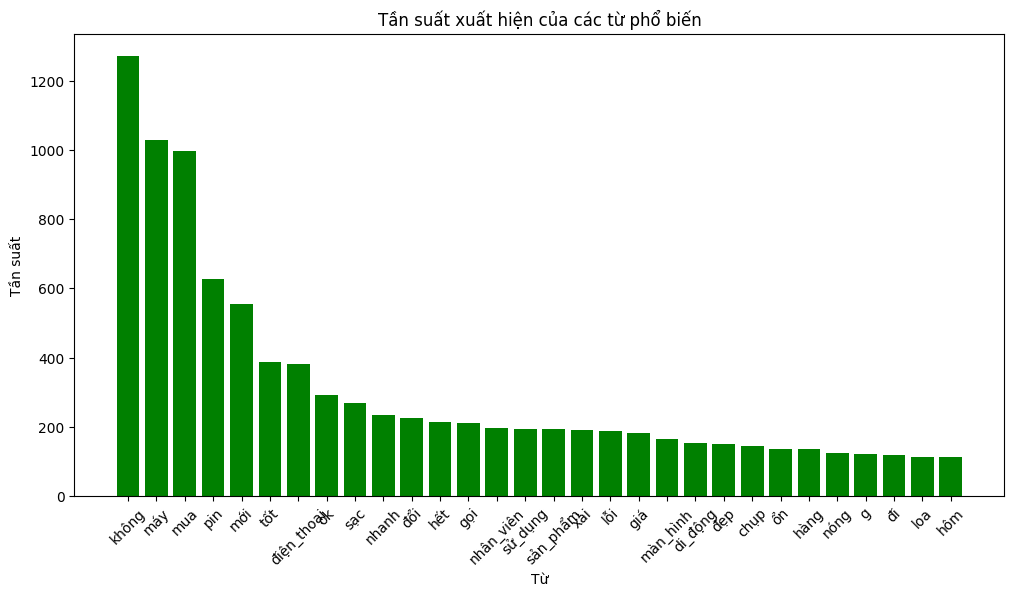

In [112]:
# Tạo biểu đồ tần suất từ
all_words = " ".join(df["comment_clean"].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)  # Lấy 20 từ phổ biến nhất

words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="green")
plt.xticks(rotation=45)
plt.xlabel("Từ")
plt.ylabel("Tần suất")
plt.title("Tần suất xuất hiện của các từ phổ biến")
plt.show()

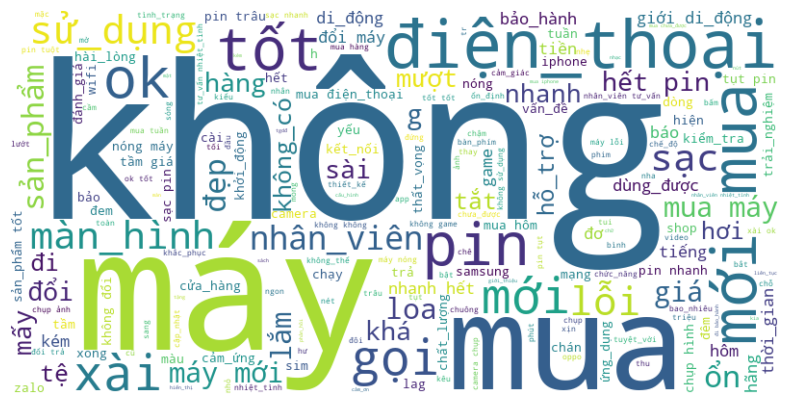

In [113]:
all_comments = " ".join(df["comment_clean"])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    all_comments
)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # No axes for word cloud
plt.show()

### Check lại kết quả sau khi tokenize
![image.png](../assets/illustration/incorrect-tokenize.png)

In [114]:
# Tìm các phần tử chứachứa từ 'pin' bên trong các bình luận ở mảng all_comments
pin_comments = set([comment for comment in all_comments.split() if "pin" in comment])
pin_comments

{'aod_pin',
 'bi_pin',
 'bây_pin',
 'bình_pin',
 'bền_pin',
 'cam_pin',
 'chuyên_pin',
 'công_pin',
 'cảm_pin',
 'di_pin',
 'dung_pin',
 'ghê_pin',
 'grab_pin',
 'hao_pin',
 'ip11_pin',
 'mát_pin',
 'mượt_pin',
 'ngon_pin',
 'nhanh_nhạy_pin',
 'nóng_pin',
 'philippines',
 'phổ_thông_pin',
 'pin',
 'pin_bền',
 'pin_cài',
 'pin_dung',
 'pin_dỏm',
 'pin_hao',
 'pin_mạng',
 'pin_mặc',
 'pin_ok',
 'pin_phiền',
 'pin_sài',
 'pin_sạc',
 'pin_thể',
 'pin_tuột',
 'pin_tệ',
 'pin_tụt',
 'pin_tụt_nhanh',
 'pin_xài',
 'pin_yếu',
 'sạc_pin',
 'sạch_pin',
 'sạcsạc_pin',
 'tháo_pin',
 'thượng_pin',
 'thị_pin',
 'to_pin',
 'to_trù_pin',
 'trở_pin',
 'tuyệt_pin',
 'tuần_pin',
 'tuột_pin',
 'tệ_pin',
 'tối_ưu_pin',
 'tốt_pin',
 'tội_pin',
 'tụt_pin',
 'vô_pin',
 'vận_chuyển_pin',
 'áp_pin',
 'đèn_pin',
 'đẹp_pin',
 'định_pin',
 'đối_pin',
 'ổn_pin'}

In [115]:
df.drop(columns=["word_count", "source_file"], inplace=True)

In [116]:
columns = ["product_id", "comment", "comment_clean", "rating"]

df = df[columns]
df

,product_id,comment,comment_clean,rating
0,honor-x8b,đừng mua không có linh kiện,đừng mua không_có linh_kiện,1
1,honor-x8b,máy sao cũng được ghét nhất cái zalo vui nó bá...,máy ghét_nhất zalo vui báo hiện gọi,3
2,honor-x8b,chiếc điện thoại mỏng nhất tôi từng dùng cũng ...,điện_thoại mỏng chip máy mượt,5
3,honor-x8b,sao hôm tôi mua lại không được tặng tai nghe n...,hôm mua không tặng tai_nghe giới_thiệu hôm đấy,4
4,honor-x8b,em mua được tuần trả lại mất bao nhiêu ạ,mua tuần trả bao_nhiêu,3
...,...,...,...,...
2308,xiaomi-redmi-note-13,camera tệ thật,camera tệ,5
2309,xiaomi-redmi-note-13,dùng thời gian có hiện tượng giật giật không c...,thời_gian hiện_tượng giật_giật không cảm_ứng đ...,3
2310,xiaomi-redmi-note-13,tôi thấy con note này chỉ mỗi pin không ổn nha...,note pin không ổn nhanh hết pin không trâu lắm...,3
2311,xiaomi-redmi-note-13,vừa mua xong thì giá giảm nên nhìn cái điện th...,mua xong giá điện_thoại không ưa nổi_giới di_đ...,2


In [117]:
df.to_csv("../data/phone_ratings_cleaned_final.csv", index=False)